# First Year Project
## Project 2 - COVID-19 and the Weather, ITU Copenhagen

This notebook contains all of the code developed for project 2. Completing tasks similar to data scientists working for a public health agency, this project seeks to inform central governments about possible correlates between COVID-19 and environmental factors facilitating or hampering its spread. We explore the latest data set of all infections from February 2020 until February 2021 provided by the government, and weather data from the IBM Pairs system.

We explore the data from **The Netherlands**.

Nicola (niccl@itu.dk)<br>
Emma (ebis@itu.dk)<br>
Karlis (kabu@itu.dk)<br>
Kirstine (kirp@itu.dk)<br>
Danielle (ddeq@itu.dk)<br>

Created: 03-03-2021
<br>Last modified: 19-03-2021

# Data Sources

**Country Metadata**:<br>
        "iso3166-1":"https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2",<br>
        "iso3166-2":"https://en.wikipedia.org/wiki/ISO_3166-2",<br>
        "population":"https://opendata.cbs.nl/statline/#/CBS/nl/dataset/70072NED/table?fromstatweb",<br>
        "geo_data":"https://www.naturalearthdata.com/downloads/10m-cultural-vectors/",<br>
        "geo_data_comments":"Filtered to 'Province', hereby excluding NL regions in the Caraïben.",<br>

**Weather Data**: IBM PAIRS, that provides highly localized, geospatial and temporal data
https://ibmpairs.mybluemix.net/

**COVID-19 Data**: Open Source Data Initiative: "https://github.com/J535D165/CoronaWatchNL" , which collects numbers on COVID-19 disease count cases in The Netherlands. The numbers are collected from various sources on a daily basis, like RIVM (National Institute for Public Health and the Environment), LCPS (Landelijk Coördinatiecentrum Patiënten Spreiding), NICE (Nationale Intesive Care Evaluatie), and the National Corona Dashboard. This project standardizes, and publishes data and makes it Findable, Accessible, Interoperable, and Reusable (FAIR).<br>
Covid Data Path: "https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/data-json/data-provincial/RIVM_NL_provincial_latest.json"<br>

**GeoJson Data** "https://www.naturalearthdata.com/downloads/10m-cultural-vectors/",<br>
The Netherlands shapefile is a GeoJson that contains Polygons of geographic regions of the Netherlands. GeoJson is an open standard format, meaning that the standard is publicly available, designed for representing simple geographical features, along with their non-spatial attributes.

## Imports

We used the following to pip installs for working collaboratively on deepnote

In [1]:
#!pip install shapely

In [2]:
#!pip install statsmodels

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import folium
import pandas as pd

import sys
import json
import shapely
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import folium
from folium.plugins import HeatMap, MarkerCluster
from IPython.core.display import display, HTML
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
import statistics as st
from datetime import datetime, timedelta

from datetime import datetime
import scipy.stats as stats

## Functions

In [4]:
def five_num_sum(data):
    """
    A function that takes the input data and calculates the five number summary.
    """
    quartiles = np.percentile(data, [25, 50, 75])
    data_min, data_max = min(data), max(data)
    
    print('Min: %.3f' % data_min)
    print('Q1: %.3f' % quartiles[0])
    print('Median: %.3f' % quartiles[1])
    print('Q3: %.3f' % quartiles[2])
    print('Max: %.3f' % data_max)
    print("")

In [5]:
def plotting_num(weather_numerical_var, axis1, title):
    """
    A function that takes data as input to create a scatter plot
    on the axis of the months from March 2020 to Febuary 2021. Used in task 0.
    """
    axs[axis1].plot_date(NL_merged_2week["date_x"], weather_numerical_var, "tab:pink", marker='', linestyle='-')
    axs[axis1].set_title(title)
    axs[axis1].set_xticks([])

In [6]:
def bar_plots_yay(ax0, ax1, y, title, ylab):
    """"
    Function to make bar plots
    """
    axes[ax0, ax1].bar(NL_merged_by_region_name["region_name"], y, color="lightblue")
    axes[ax0, ax1].set_title(title)
    axes[ax0, ax1].set_ylabel(ylab)
    axes[ax0, ax1].set_xlabel("Regions")

In [7]:
def double_var_plots(a, b, data1, maintitle, xlabel):
    """
    Function to make scatterplots for COVID-19 Cases per day
    """
    axes[a, b].scatter(data1, NL_merged_2week["confirmed_addition"], color= "lightblue", edgecolor="blue",s=0.25)
    slope, intercept, r_value, p_value, std_err = stats.linregress(data1, NL_merged_2week["confirmed_addition"])
    axes[a, b].plot(data1, intercept + slope*data1, 'red')
    axes[a, b].set_title(maintitle)
    axes[a, b].set_xlabel(xlabel)

In [8]:
def double_var_uv(a, b, data1, maintitle, xlabel):
    """
    Function to make scatterplots for UV Index graphs
    """
    axes[a, b].scatter(data1, NL_merged_2week["UVIndex"], color= "purple", edgecolor="purple",s=0.25)
    slope, intercept, r_value, p_value, std_err = stats.linregress(data1, NL_merged_2week["UVIndex"])
    axes[a, b].plot(data1, intercept + slope*data1, 'red')
    axes[a, b].set_title(maintitle)
    axes[a, b].set_xlabel(xlabel)

In [9]:
#https://community.deepnote.com/c/general/cannot-show-folium-map-on-deepnote

def folium_deepnote_show(m):
    """
    A function that allows folium maps to show in deepnote.
    """
    data = m.get_root().render()
    data_fixed_height = data.replace('width: 100%;height: 100%', 'width: 100%').replace('height: 100.0%;', 'height: 609px;', 1)
    display(HTML(data_fixed_height))

In [10]:
def plotByRegionCode(region_code, title):
    """
    Function for plotting COVID-19 cases and UV by date 
    and region_code with two y-axes.
    """
    #isRegion = NL_merged_2week["region_code"] == region_code
    #NL_region = NL_merged_2week[isRegion]
    # We decided to plot for all of NL but for ease of programming the variable NL_merged_for_RegCode was simply given all of the NL data
    NL_merged_for_RegCode = NL_merged_2week
    fig,ax=plt.subplots(figsize=(30,10))
    ax.plot(NL_merged_for_RegCode.date_x, NL_merged_for_RegCode["UVIndex"], marker="", color="red")
    ax.set_xlabel("UV Index with 2 week delay in COVID-19 Cases", fontsize=24)
    ax.set_title(title, fontsize=40)
    ax.set_xticks(ax.get_xticks()[::20])
    ax.set_ylabel("UV-Index", fontsize=22, color = "red")
    ax2=ax.twinx()
    ax2.plot(NL_merged_for_RegCode.date_x, NL_merged_for_RegCode["confirmed_addition"], marker="", color="blue")
    ax2.set_ylabel("Confirmed addition",color="blue",fontsize=22)
    ax2.set_xticks(ax2.get_xticks()[::20]) # show a date every 20th date 
    plt.show()

In [11]:
def usable_dates_barh(booleans):
    """
    Takes the 0,1 format of the lockdown data and converts it into 
    start and length values for the lockdown bar graph
    """
    current=0
    usable=[]
    usable_t=[]
    for index,element in enumerate(booleans):
        if element!=current:
            usable.append(index)
            current=element
    if len(usable)%2!=0:
        usable.append(len(booleans))
    for index,element in enumerate(usable):
        if index%2!=0:
            usable[index]=element-usable[index-1]
    group=[]       
    for index,element in enumerate(usable):
        if index%2==0:
            group.append(element)
        elif index%2!=0:
            group.append(element)
            usable_t.append(tuple(group))
            group=[]
    return usable_t

## Constants

In [12]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

FILEPATH ={}
FILEPATH["shapefiles"] ="shapefiles/nl.geojson"
FILEPATH["weather"] = "weather/weather.csv"
FILEPATH["metadata"] = "metadata/nl_metadata.json"
FILEPATH["corona"] = "corona/nl_corona.csv"

## Task 0: Data Filtering and cleaning

### Loading weather and corona data, and geojson file.

In [13]:
# load weather data
weather_df = pd.read_csv(PATH["data_raw"]+FILEPATH["weather"], sep = "\t")
weather_update = pd.read_csv(PATH["data_raw"]+"weather/weather2.csv", sep = "\t")

# concat weather data and convert temperature from kelvin to celsius
weather_df = pd.concat([weather_df,weather_update])
weather_df["TemperatureAboveGround"] = weather_df["TemperatureAboveGround"] - 273.15

# load corona data
corona_df = pd.read_csv(PATH["data_raw"]+FILEPATH["corona"], sep = "\t")

# load shapefiles
with open(PATH["data_raw"]+FILEPATH["shapefiles"]) as f:
    json_data = json.load(f)

# load country metadata
with open(PATH["data_raw"] +FILEPATH["metadata"]) as f:
    country_metadata = json.load(f)

In [14]:
# finding shape
print(weather_df.shape)
print(corona_df.shape)

(20220, 9)
(4344, 9)


There are 20220 records with 9 fields in the raw weather data. <br>
There are 4344 records with 9 fields in the raw corona data.

In [15]:
# Change the names of the regions to match how it is spelled in the country metadata
corona_df['region_name'] = corona_df['region_name'].replace({'Noord-Holland':'North Holland', 
    'Zuid-Holland':'South Holland', 'Noord-Brabant':'North Brabant'})

#### Check for missing values
We start by checking if there is any NA

In [16]:
print(weather_df.isna().any().any())
print(corona_df.isna().any().any())

False
True


There are no missing values for weather data. 
<br> There are missing values in the corona data. First we explore where there are missing values.

In [17]:
# Find where there are missing values in the corona data
print(" \nCount total NaN at each column in a DataFrame : \n\n", 
      corona_df.isnull().sum()) 
      
print("\nTotal amount of missing values", corona_df.isnull().sum().sum()) 

 
Count total NaN at each column in a DataFrame : 

 date                         0
region_name                  0
region_code                  0
deceased_addition          192
confirmed_addition          12
hospitalized_addition      192
deceased_cumulative        180
confirmed_cumulative         0
hospitalized_cumulative    180
dtype: int64

Total amount of missing values 756


Then we wanted to narrow down the corona dataset to begin 2 weeks later, because there is only missing data in the first 2 weeks of the raw data set.

In [18]:
# Cleaning to include only between these dates: 14/03/2020 - 22/02/2021
start_date = "2020-03-14"
end_date = "2021-02-22"

after_start_date = corona_df["date"] >= start_date
before_end_date = corona_df["date"] <= end_date
between_two_dates = after_start_date & before_end_date
corona_clean = corona_df.loc[between_two_dates]

To check for missing values in the narrowed COVID-19 data

In [19]:
print(corona_clean.isna().any().any())

False


### Filtering weather data to only include data from the Netherlands

#### Netherlands iso codes and corresponding region names:
NL-DR	Drenthe<br>
NL-FL	Flevoland<br>
NL-FR	Friesland<br>
NL-GE	Gelderland<br>
NL-GR	Groningen<br>
NL-LI	Limburg<br>
NL-NB	North Brabant<br>
NL-NH	North Holland<br>
NL-OV	Overijssel<br>
NL-UT	Utrecht<br>
NL-ZE	Zeeland<br>
NL-ZH	South Holland


In [20]:
# Dictionary of the regions in the Netherlands
# Key is region name, and value is the iso code of the region
NL_Regions = {country_metadata["country_metadata"][i]["iso3166-2_code"]: 
    country_metadata["country_metadata"][i]["iso3166-2_name_en"] 
    for i in range(len(country_metadata["country_metadata"]))}

# Key is iso code, value is region name
region_map = {country_metadata["country_metadata"][i]["iso3166-2_name_en"]: 
    country_metadata["country_metadata"][i]["iso3166-2_code"] 
    for i in range(len(country_metadata["country_metadata"]))}

In [21]:
# Filter weather data for iso3166-2 code that contains "NL"
filtered_weather = weather_df[weather_df["iso3166-2"].str.contains("NL")]
print(filtered_weather.shape)

# Filter COVID-19 data for region_name 
mask_corona = corona_clean["region_name"].isin(region_map.keys())
corona_clean_NL = corona_clean[mask_corona]
print(corona_clean_NL.shape)


(4500, 9)
(4152, 9)


There are 4500 records in the NL weather data.
<br>There are 4152 records in the NL corona data, after narrowing the dates.

Verify that that there are no missing values in the clean corona datasheet:

In [22]:
print(" \nCount total NaN at each column in a DataFrame : \n\n", 
      corona_clean_NL.isnull().sum()) 
       
print("\nTotal amount of missing values",
 corona_clean_NL.isnull().sum().sum())

 
Count total NaN at each column in a DataFrame : 

 date                       0
region_name                0
region_code                0
deceased_addition          0
confirmed_addition         0
hospitalized_addition      0
deceased_cumulative        0
confirmed_cumulative       0
hospitalized_cumulative    0
dtype: int64

Total amount of missing values 0


During the course of the pandemic many countries have been not adding numbers to the tally during the weekend, but have added all of the weekend data on Monday. So it could be that this was the case here in the Netherlands as well where there was missing values before we had narrowed down the data set. Perhaps it would be beneficial to see which days the missing data falls on, as a weekend day would confirm this.<br>
It is also assumed that variabeles with missing values occured when there was no instance of a variable occuring. For instance, no deaths on a given day and therefore nothing to report. 

We filtered for NL in the iso3166-2 code. This code could, however include Netherlands territories that are outside of the geospatial location of the Netherlands, such as Aruba, which could impact data analysis.

In [23]:
mask_weather = weather_df["iso3166-2"].isin(region_map.values())
NL_weather = weather_df[mask_weather]
print(NL_weather.shape)

(4500, 9)


There are 4500 records of data with 9 fields.

We filtered to verify that there are only codes present that are related to the provinces of the Netherlands. We see that the data is the same shape with either filter, thereby confirming that we are only including data from the country of the Netherlands, and not the entire Kingdom of the Netherlands.

### Creating Merged NL Data Frame with   2 week delay in COVID-19 data

In [24]:
# Use the Series.map function to add the ISO code to the COVID-19 data using the region dictionary
corona_clean_NL["region"] = corona_clean_NL["region_name"].map(region_map)

corona_clean_NL.insert(1, "date-2week", "NaN", True)

for index,date in enumerate(corona_clean_NL["date"]):
    index+=192
    original_date = datetime.strptime(date,"%Y-%m-%d")
    new_date_2weeks = original_date + timedelta(-14)
    str_date_2weeks = new_date_2weeks.strftime("%Y-%m-%d")
    corona_clean_NL.loc[index,"date-2week"] = str_date_2weeks

https://www.tutorialspoint.com/python/time_strptime.htm

### Merging into merged_2week
#### Both weather data and COVID-19 data consists of exactly 346 days.

We merge the COVID-19 and weather data with a 2 week delay in COVID-19 data. This is done based on the discussion that there is an incubation period of up to 2 weeks with COVID-19, therefore the number of cases affected by a weather variable can take 2 weeks to take effect. We can now do statistical analysis using this delay, and see if any stand out.

In [25]:
# Merge weather and COVID-19 data
NL_merged_2week = corona_clean_NL.merge(NL_weather, left_on = ["date-2week", "region"], right_on = ["date", "iso3166-2"])

# Delete duplicate column
NL_merged_2week = NL_merged_2week.drop(["region"], axis = 1)

In [26]:
# How much have we lost when merging

# Start dates of data
print("Start of weather data: ",NL_weather["date"].head(1))
print("Start of corona data: ",corona_clean_NL["date"].head(1))
print("Start of merged 2 week delay data:\n","Corona date: ",NL_merged_2week["date_x"].head(1),"\n","Weather date: ",NL_merged_2week["date_y"].head(1))
print("\nAt the start of the merge we cut off 2 or 3.5 weeks of the weather data")
# End dates of data
print(" \n")
print("End of weather data: ",NL_weather["date"].tail(1))
print("End of corona data: ",corona_clean_NL["date"].tail(1))
print("End of merged 2 week delay data:\n","Corona date: ",NL_merged_2week["date_x"].tail(1),"\n","Weather date: ",NL_merged_2week["date_y"].tail(1))
print("\nAt the end of the merge we cut off 1 or 2 weeks of the weather data")
print("\nNo corona data is lost when merging, the only data lost for the corona dataset is when removing the first weeks\n during the initial cleaning. This was done to remove missing values")


Start of weather data:  21    2020-02-13
Name: date, dtype: object
Start of corona data:  192    2020-03-14
Name: date, dtype: object
Start of merged 2 week delay data:
 Corona date:  0    2020-03-14
Name: date_x, dtype: object 
 Weather date:  0    2020-02-29
Name: date_y, dtype: object

At the start of the merge we cut off 2 or 3.5 weeks of the weather data
 

End of weather data:  5294    2021-02-21
Name: date, dtype: object
End of corona data:  4343    2021-02-22
Name: date, dtype: object
End of merged 2 week delay data:
 Corona date:  4151    2021-02-22
Name: date_x, dtype: object 
 Weather date:  4151    2021-02-08
Name: date_y, dtype: object

At the end of the merge we cut off 1 or 2 weeks of the weather data

No corona data is lost when merging, the only data lost for the corona dataset is when removing the first weeks
 during the initial cleaning. This was done to remove missing values


### Adding external data to our merged dataset. Netherlands lockdown data comes from: 
https://www.government.nl/latest/news?keyword=&start-date=&end-date=&element=All+ministries

Schools closed: 12 March - 2 June 2021.  December 15 2020 - 1 March 2021<br>
Lockdown: 12 March - 1 June 2020. 14 October 2020 - 15  March 2021<br>
Travel ban: 12 Jan 2021 - Mar 31 2021<br>

In [27]:
# Add variables to the dataframe that show lockdown measures in the Netherlands, initially set to 0
NL_merged_2week["school_closed"] = 0
NL_merged_2week["lockdown"] = 0
NL_merged_2week["travel_ban"] = 0

# First wave of lockdown measures
NL_merged_2week.loc[(NL_merged_2week["date_x"] >= "2020-03-12") & (NL_merged_2week["date_x"] <= "2020-06-02"), "school_closed"] = 1
NL_merged_2week.loc[(NL_merged_2week["date_x"] >= "2020-03-12") & (NL_merged_2week["date_x"] <= "2020-06-01"), "lockdown"] = 1

# Second wave of lockdown measures
NL_merged_2week.loc[(NL_merged_2week["date_x"] >= "2020-12-05") & (NL_merged_2week["date_x"] <= "2021-03-01"), "school_closed"] = 1
NL_merged_2week.loc[(NL_merged_2week["date_x"] >= "2020-10-14") & (NL_merged_2week["date_x"] <= "2021-03-15"), "lockdown"] = 1
NL_merged_2week.loc[(NL_merged_2week["date_x"] >= "2021-01-12"), "travel_ban"] = 1

# Export the merged dataset that includes COVID-19, Weather, and lockdown data regarding the Netherlands
NL_merged_2week.to_csv(PATH["data_processed"]+"merged_NL_data")

## Five Number Summary of Numerical Variables

**Numerical variables of COVID-19 Data**: <br>
deceased_addition<br>
confirmed_addition<br>
hospitalized_addition<br>
deceased_cumulative<br>
confirmed_cumulative<br>
hospitalized_cumulative<br>

**Numerical variables of Weather Data**: <br>
RelativeHumiditySurface<br>
SolarRadiation<br>
Surfacepressure<br>
TemperatureAboveGround<br>
Totalprecipitation<br>
UVIndex<br>
WindSpeed<br>

In [28]:
# five number summary for deceased_addition
print("Five Number Summary for deceased_addition")
deceased_addition = corona_clean_NL["deceased_addition"]
mask_d = deceased_addition > -1
five_num_sum(deceased_addition[mask_d])

# five number summary for confirmed_addition
print("Five Number Summary for confirmed_addition")
confirmed_addition = corona_clean_NL["confirmed_addition"]
mask_c = confirmed_addition > -1
five_num_sum(confirmed_addition[mask_c])

# five number summary for hospitalized_addition
print("Five Number Summary for hospitalized_addition")
hospitalized_addition = corona_clean_NL["hospitalized_addition"]
mask_h = hospitalized_addition > -1
five_num_sum(hospitalized_addition[mask_h])

# five number summary for deceased_cumulative
print("Five Number Summary for deceased_cumulative")
deceased_cumulative = corona_clean_NL["deceased_cumulative"]
five_num_sum(deceased_cumulative)

# five number summary for confirmed_cumulative
print("Five Number Summary for confirmed_cumulative")
confirmed_cumulative = corona_clean_NL["confirmed_cumulative"]
five_num_sum(confirmed_cumulative)

# five number summary for hospitalized_cumulative
print("Five Number Summary for hospitalized_cumulative")
hospitalized_cumulative = corona_clean_NL["hospitalized_cumulative"]
five_num_sum(hospitalized_cumulative)

Five Number Summary for deceased_addition
Min: 0.000
Q1: 0.000
Median: 1.000
Q3: 4.000
Max: 77.000

Five Number Summary for confirmed_addition
Min: 0.000
Q1: 10.750
Median: 76.000
Q3: 277.000
Max: 3179.000

Five Number Summary for hospitalized_addition
Min: 0.000
Q1: 0.000
Median: 1.000
Q3: 6.000
Max: 270.000

Five Number Summary for deceased_cumulative
Min: 0.000
Q1: 70.000
Median: 314.000
Q3: 874.000
Max: 3653.000

Five Number Summary for confirmed_cumulative
Min: 4.000
Q1: 1175.250
Median: 6526.000
Q3: 20097.250
Max: 250759.000

Five Number Summary for hospitalized_cumulative
Min: 0.000
Q1: 163.000
Median: 624.000
Q3: 1752.250
Max: 6043.000



#### Aggregate weather data by date and calculate the mean of all numeric columns

In [55]:
# Mean of Numerical Variables in Weather Data
print("RelativeHumiditySurface Mean: ",  round(st.mean(NL_weather["RelativeHumiditySurface"]),3))
print("SolarRadiation Mean: ", round(st.mean(NL_weather["SolarRadiation"]),3))
print("SurfacePressure Mean: ", round(st.mean(NL_weather["Surfacepressure"]),3))
print("TemperatureAboveGround Mean: ",  round(st.mean(NL_weather["TemperatureAboveGround"]),3))
print("Totalprecipitation Mean: ",  round(st.mean(NL_weather["Totalprecipitation"]),4))
print("UVIndex Mean: ",  round(st.mean(NL_weather["UVIndex"]),3))
print("WindSpeed Mean: ",  round(st.mean(NL_weather["WindSpeed"]),3))

RelativeHumiditySurface Mean:  77.727
SolarRadiation Mean:  6760242.831
SurfacePressure Mean:  2430896.598
TemperatureAboveGround Mean:  11.149
Totalprecipitation Mean:  0.0025
UVIndex Mean:  15.609
WindSpeed Mean:  4.507


### Plot Numerical (Single) Variables for weather data

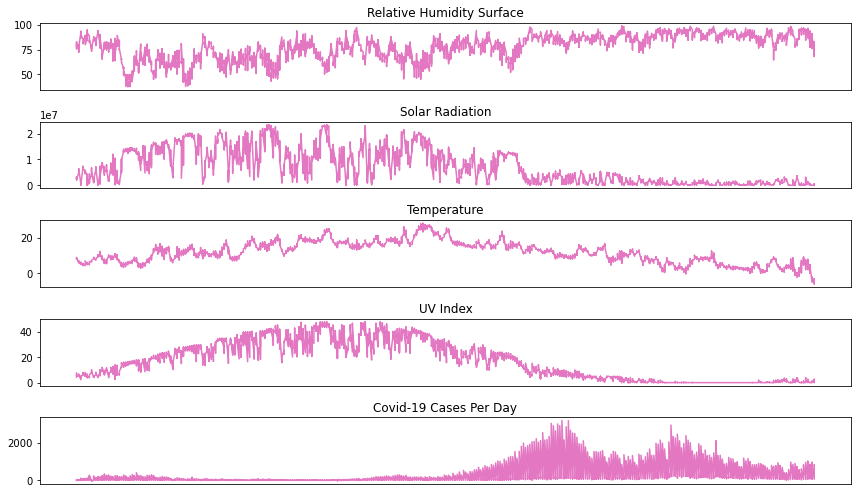

In [30]:
fig, axs = plt.subplots(5, 1, figsize=(12,7))
fig.tight_layout()
plotting_num(NL_merged_2week["RelativeHumiditySurface"], 0, "Relative Humidity Surface")
plotting_num(NL_merged_2week["SolarRadiation"], 1, "Solar Radiation")
plotting_num(NL_merged_2week["TemperatureAboveGround"], 2, "Temperature")
plotting_num(NL_merged_2week["UVIndex"], 3, "UV Index")
plotting_num(NL_merged_2week["confirmed_addition"], 4, "Covid-19 Cases Per Day")

plt.savefig("../reports/figures/task1stacked.png")

At first we plotted all of the numerical values for the weather data, just to get a better understanding of how the variables changed over the course of the timeline of our data. For the report, we focus on the four variables that stand out during statistical analysis: **Humidity**, **Solar Radiation**, **Temperature**, and **UV Index**.

# Task 1 Single Variable Analysis

## Weather Variables by Region

In [31]:
weather_by_region = NL_weather.groupby(by = "iso3166-2").agg(["min", "mean", "median", "max"])

# Put min, mean, med, max in a dictionary for future reference
av_weather_by_region_dict={}
for key in NL_Regions.keys():
    mask= NL_weather["iso3166-2"]==key
    av_weather_by_region_dict[NL_Regions[key]]=NL_weather.agg(["min", "mean", "median", "max"])
print(av_weather_by_region_dict["Limburg"])

              date iso3166-2  RelativeHumiditySurface  SolarRadiation  \
min     2020-02-13     NL-DR                37.385233    0.000000e+00   
max     2021-02-21     NL-ZH                98.944014    2.345213e+07   
mean           NaN       NaN                77.727370    6.760243e+06   
median         NaN       NaN                80.148827    4.430901e+06   

        Surfacepressure  TemperatureAboveGround  Totalprecipitation  \
min        2.327900e+06               -6.964946            0.000000   
max        2.499047e+06               28.021134            0.024162   
mean       2.430897e+06               11.149420            0.002450   
median     2.433860e+06               10.950497            0.000795   

          UVIndex  WindSpeed  
min      0.000000   0.720075  
max     48.000000  13.778154  
mean    15.609025   4.507447  
median  11.626403   4.155131  


## COVID-19 Cases Per Region and Population Per Region

In [32]:
# Calculate total number of cases per region
corona_df_by_region = corona_clean_NL.groupby(by = "region")["confirmed_addition"].sum().reset_index()

# Dictionary mapping from the region iso3166-2 code to the region's population from country metadata
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"] for i in range(len(country_metadata["country_metadata"]))}

# Add the population data to this new df
corona_df_by_region["population"] = corona_df_by_region["region"].map(population_map)


In [33]:
# Group the data by region_name so that it is easier to plot
NL_merged_by_region_name = NL_merged_2week.groupby(by = "region_name")["deceased_addition","confirmed_addition","hospitalized_addition",
    "deceased_cumulative","confirmed_cumulative","hospitalized_cumulative","RelativeHumiditySurface","SolarRadiation",
    "Surfacepressure","TemperatureAboveGround","Totalprecipitation","UVIndex","WindSpeed"].sum().reset_index()

# Add cases per thousand of the population
corona_df_by_region["cases_per_mille"] = corona_df_by_region["confirmed_addition"]/(corona_df_by_region["population"]/1000)

# Add average UV index per region
average_UV=list(weather_by_region["UVIndex"]["mean"])
corona_df_by_region.insert(4, "Average_UV", average_UV, True)

<ipython-input-33-f51aaf04d54d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  NL_merged_by_region_name = NL_merged_2week.groupby(by = "region_name")["deceased_addition","confirmed_addition","hospitalized_addition",


## Potential correlation of UV and COVID-19 cases per dates and Region.
#### Graphs with two y-axes: The dates are the COVID-19 dates - and then used with 2 weeks delay of weather dates


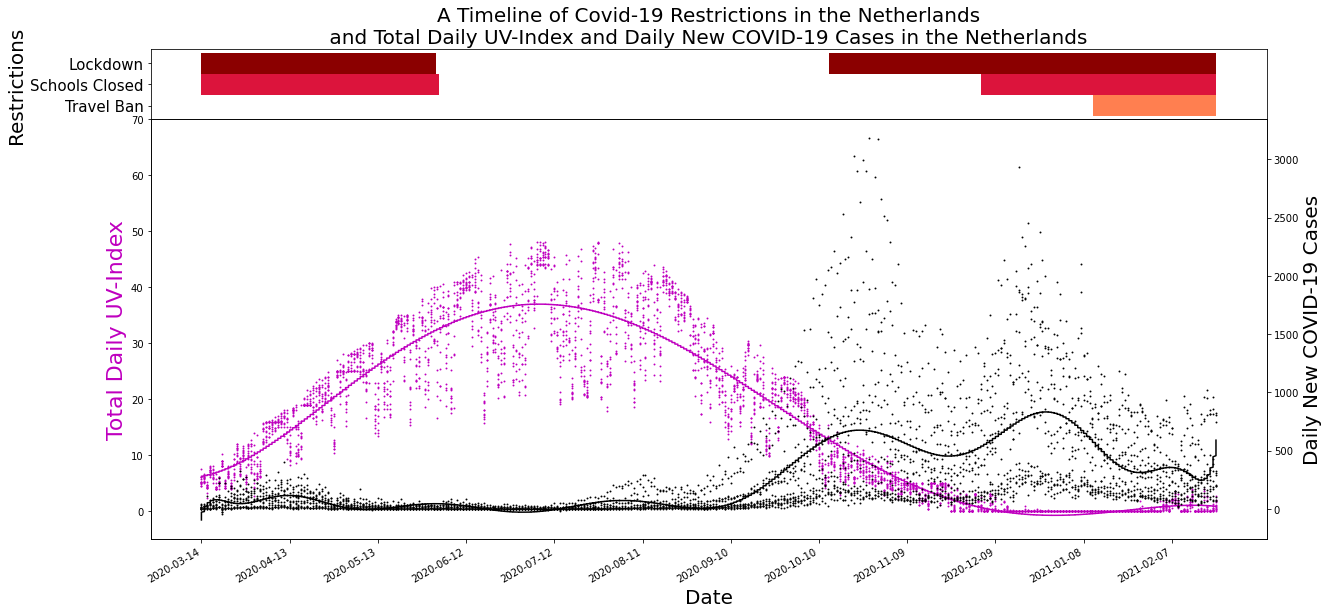

In [34]:
#setup
fig, ax = plt.subplots(2,figsize=(20,10),gridspec_kw={'height_ratios': [1, 6]},sharex=False)
ax2=ax[1].twinx()
plt.subplots_adjust(hspace=.0)
fig.autofmt_xdate(rotation=30)
#ax0
ax[0].set_title("A Timeline of Covid-19 Restrictions in the Netherlands\n and Total Daily UV-Index and Daily New COVID-19 Cases in the Netherlands ", fontsize=20)
ax[0].broken_barh(usable_dates_barh(list(NL_merged_2week["school_closed"])), (20, 10), facecolors='crimson')
ax[0].broken_barh(usable_dates_barh(list(NL_merged_2week["lockdown"])), (30, 10), facecolors='darkred')
ax[0].broken_barh(usable_dates_barh(list(NL_merged_2week["travel_ban"])), (10, 10), facecolors='coral')
#ax[0].set_xlabel("Date", fontsize=20)
ax[0].set_ylabel("Restrictions", fontsize=20)
ax[0].set_yticks([15, 25,35])
ax[0].set_yticklabels(["Travel Ban", "Schools Closed","Lockdown"],fontsize=15)
ax[0].set_xticks([])
#ax1
x=np.linspace(0,4152,4152)
fit_UV=np.polyfit(x, NL_merged_2week["UVIndex"],5)
fit_eq_UV=np.poly1d(fit_UV)
ax[1].plot(NL_merged_2week.date_x, fit_eq_UV(x), marker="", color="m")
ax[1].set_xlabel("Date", fontsize=20)
ax[1].scatter(NL_merged_2week["date_x"], NL_merged_2week["UVIndex"], marker="o", color="m",s=0.85)
ax[1].set_ylim([-5,70])
ax[1].set_ylabel("Total Daily UV-Index", fontsize=22, color = "m")

#ax0 right hand side
fit_CA=np.polyfit(x, NL_merged_2week["confirmed_addition"],15)
fit_eq_CA=np.poly1d(fit_CA)
ax2.plot(NL_merged_2week.date_x, fit_eq_CA(x), marker="", color="k")
ax2.scatter(NL_merged_2week["date_x"], NL_merged_2week["confirmed_addition"], marker="o", color="k",s=0.85)
ax2.set_ylabel("Daily New COVID-19 Cases",color="k",fontsize=20)

ax2.set_xticks(ax2.get_xticks()[::30]) # show every 30th date
plt.savefig("../reports/figures/task4withline.png")

Above we created a graph to visualise the lockdown periods in the netherlands. This was done using the usable_dates_barh function which formats the 0,1 boolean values for each type of restriction into a format that the barh graph can plot.

### Single Variable Bar plots for relevant data by Region

Text(0.5, 0, 'Regions')

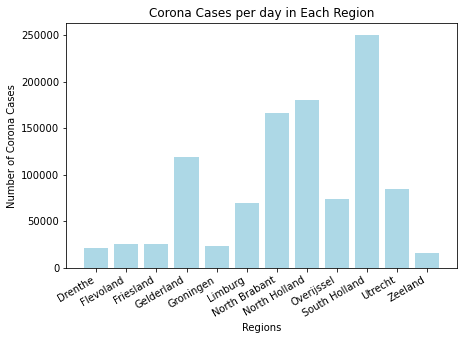

In [35]:
# Plotting COVID-19 Cases Per Day by Region
fig, axes = plt.subplots(1,1,figsize=(7,5))
fig.autofmt_xdate(rotation=30)

plt.bar(NL_merged_by_region_name["region_name"],NL_merged_by_region_name["confirmed_addition"], color="lightblue")
plt.title("Corona Cases per day in Each Region")
plt.ylabel("Number of Corona Cases")
plt.xlabel("Regions")

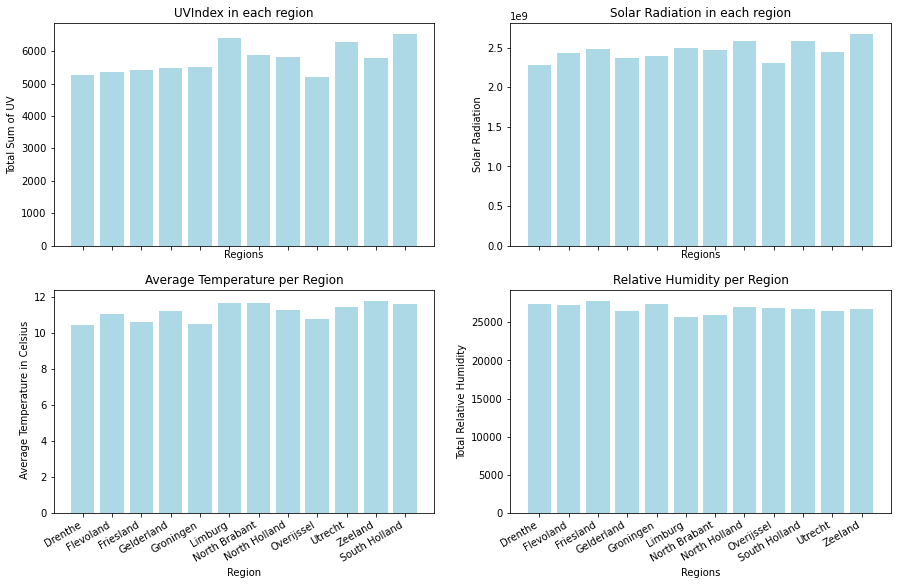

In [36]:
# Plotting UV Index, Solar Radiation,  Average Temperature, Relative Humidity in each Region
fig, axes = plt.subplots(2,2,figsize=(15,10))
fig.autofmt_xdate(rotation=30)

bar_plots_yay(0, 0, NL_merged_by_region_name["UVIndex"], "UVIndex in each region", "Total Sum of UV")
bar_plots_yay(0, 1, NL_merged_by_region_name["SolarRadiation"], "Solar Radiation in each region", "Solar Radiation")
bar_plots_yay(1, 1, NL_merged_by_region_name["RelativeHumiditySurface"], "Relative Humidity per Region", "Total Relative Humidity")

# Plotting Temperature above ground
x_values=[]
for i in weather_by_region.index:
    x_values.append(NL_Regions[i])

axes[1,0].bar(x_values,weather_by_region["TemperatureAboveGround"]["mean"], color="lightblue")
axes[1,0].set_title("Average Temperature per Region")
axes[1,0].set_xlabel("Region")
axes[1,0].set_ylabel(" Average Temperature in Celsius")

plt.show()

### Two Variable Plots (with the line of best fit).

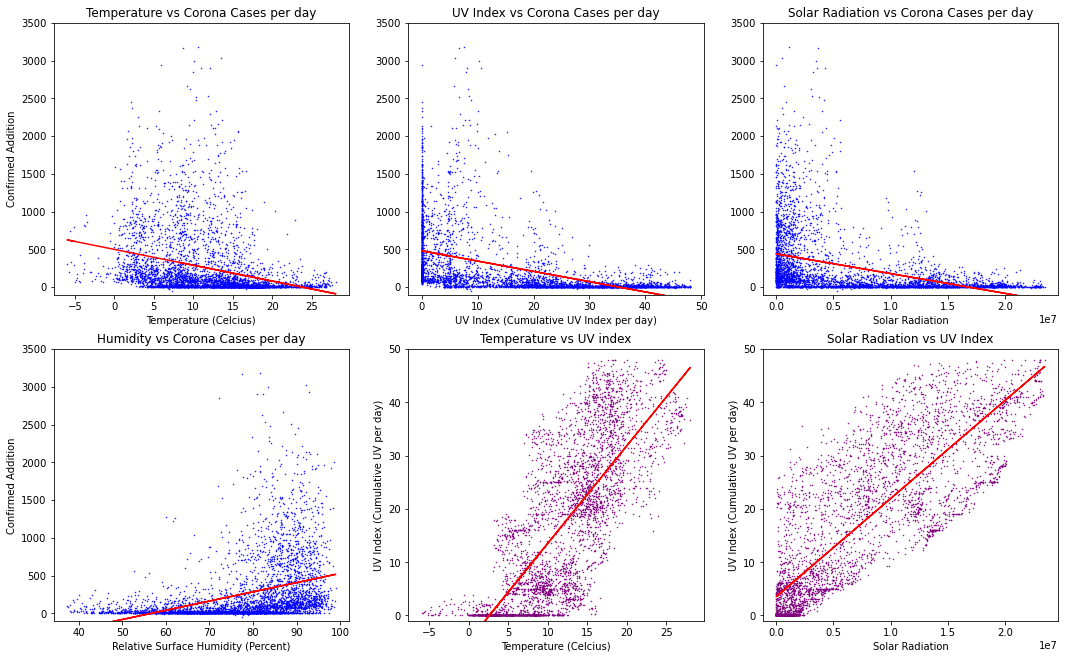

In [37]:
fig, axes = plt.subplots(2,3,figsize=(18,11))

axes[0, 0].set_ylabel("Confirmed Addition")
axes[1, 0].set_ylabel("Confirmed Addition")
axes[1, 1].set_ylabel("UV Index (Cumulative UV per day)")
axes[1, 2].set_ylabel("UV Index (Cumulative UV per day)")

double_var_plots(0, 0, NL_merged_2week["TemperatureAboveGround"], "Temperature vs Corona Cases per day", "Temperature (Celcius)")
double_var_plots(0, 1, NL_merged_2week["UVIndex"], "UV Index vs Corona Cases per day", "UV Index (Cumulative UV Index per day)")
double_var_plots(0, 2, NL_merged_2week["SolarRadiation"], "Solar Radiation vs Corona Cases per day", "Solar Radiation")
double_var_plots(1, 0, NL_merged_2week["RelativeHumiditySurface"], "Humidity vs Corona Cases per day", "Relative Surface Humidity (Percent)")
double_var_uv(1, 1, NL_merged_2week["TemperatureAboveGround"], "Temperature vs UV index", "Temperature (Celcius)")
double_var_uv(1, 2, NL_merged_2week["SolarRadiation"], "Solar Radiation vs UV Index", "Solar Radiation")
axes[0, 0].set_ylim(-100,3500)
axes[0, 1].set_ylim(-100,3500)
axes[0, 2].set_ylim(-100,3500)
axes[1, 0].set_ylim(-100,3500)
axes[1, 1].set_ylim(-1,50)
axes[1, 2].set_ylim(-1,50)

plt.savefig("../reports/figures/task2grapes.png")

# Task 2: Associations

### The titles of variables in weather data sheet

In [38]:
# List of the variables we want to use as predictors
Xs = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed']

# Since we are running a lot of tests, we need to correct for multiple hypothesis testing using the Bonferroni correction. 
# If we run N tests and we determine our significance threshold as a p-value of 0.001, 
# then we need to make sure that the p-values we look at are lower than 0.001 / N. Multiply the length of Xs by three, 
# because we are running three correlations per variable (linear, Spearman, and log).
significance_threshold = 0.001 / (len(Xs) * 3)


## Pearson Test to check for linear correlation

In [39]:
# Print the variable name, the correlation coefficient and whether the correlation is significant.
corrs = []
pvalues = []
for var in Xs:
    corr, pvalue = pearsonr(NL_merged_2week["confirmed_addition"], NL_merged_2week[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")


RelativeHumiditySurface
0.371	1.0516842989787682e-135	True

SolarRadiation
-0.408	6.519609723204714e-166	True

Surfacepressure
-0.152	6.726753250615707e-23	True

TemperatureAboveGround
-0.302	4.441160216748292e-88	True

Totalprecipitation
0.091	4.567416231254187e-09	True

UVIndex
-0.467	1.1951602219713268e-223	True

WindSpeed
0.029	0.0632279949382412	False



The correlation coefficient ranges between -1 and 1. Closer to -1 indicates a total negative correlation, while 1 indicates a total positive correlation. A correlation coefficient of 0 indicates that there is no correlation. 

The pearson test evaluates a linear relationship between two variables, which is when a change in one variable is associated with a proportional change in the other variable.
The test shows that there is a correlation between all variables in the weather data and corona cases.<br>

There is a positive correlation between cases and relative humidity, total precipitation, and windspeed. The correlation coefficient of **relative humidity** is highest, at **0.371**, indicating that there is a stronger correlations with corona cases and relative humidity. The correlation coefficient of the other two is quite low, indicating that the correlation is not so strong.<br>

There is a negative correlation between cases and solar radiation, surface pressure, temperature above ground, and UV index. The correlation coefficients of **UV index** and **solar radiation** are the lowest, at **-0.467 and -0.408**, which is quite high and indicates a stronger correlation.

## Spearman Test

In [40]:
# Second test, using a Spearman rank correlation
for var in Xs:
    corr, pvalue = spearmanr(NL_merged_2week["confirmed_addition"], NL_merged_2week[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

RelativeHumiditySurface
0.520	4.1565032710682984e-286	True

SolarRadiation
-0.585	0.0	True

Surfacepressure
-0.152	8.45816072613243e-23	True

TemperatureAboveGround
-0.474	3.392182570462779e-231	True

Totalprecipitation
0.155	9.720495016973928e-24	True

UVIndex
-0.703	0.0	True

WindSpeed
0.057	0.00022646135057273684	False



The spearman correlation evaluates the monotonic relationsip between two variables based on rank: testing whether a change in one variable is associated with the change in another, but not necessarily proportionally.

The spearman test shows that there is a correlation between all variables in the weather data and corona cases.<br>
There is a positive correlation between cases and relative humidity, total precipitation, and windspeed. Again, **relative humidity** has the highest correlation coefficient at **0.520**, while the other two variables have barely increased compared with the pearson test, and remain very low. This indicates a very low correlation regarding precipitation and windspeed with corona cases.<br>
There is a negative correlation between cases and solar radiation, surface pressure, temperature above ground, and UV index. With this test, **solar radiation**, **temperature**, and **UV index** have quite high correlation coefficients at **-0.585, -0.474, and -0.703** respectively. **UV index** stands out, and the cc indicates a very strong correlation.

## Log Transformed Pearson Correlation

In [41]:
# Do this for log functions where you want everything above 0
NL_merged_no_0 = NL_merged_2week["confirmed_addition"].clip(lower=0.1)

# Third run of statistical test, for a log-transformed Pearson correlation
for var in Xs:
    corr, pvalue = pearsonr(np.log(NL_merged_no_0), NL_merged_2week[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

RelativeHumiditySurface
0.413	4.457668093960007e-171	True

SolarRadiation
-0.515	2.3910169253022213e-280	True

Surfacepressure
-0.159	7.158939440647317e-25	True

TemperatureAboveGround
-0.427	1.808785233938912e-183	True

Totalprecipitation
0.082	1.2487071184164006e-07	True

UVIndex
-0.655	0.0	True

WindSpeed
0.051	0.0010055878496832078	False



The pearson test with log transformation shows that there is a correlation between all variables in the weather data and corona cases.<br>
There is a positive correlation between cases and relative humidity, total precipitation, and windspeed. **Humidity** stands out with .386 correlation coeffient, while the other two have negligible correlation coefficients in this test.<br>

There is a negative correlation between cases and solar radiation, surface pressure, temperature above ground, and UV index. **Solar ratiation**, **temperature**, and **UV index** again stand out with -.512, -.495, and -.696 respectively.<br>

This test allows us to be more confident with the values that have a low correlation, because those that were low seem to almost drop out completely, with windspeed having a coefficient of .095. 

### Summary of the correlation tests:
All tests show the same variables have positive or negative correlations. <br>

The spearman rank test highlights those variables in our data that have a stronger correlation coefficient, while the log transform pearson test seems to emphasize which variables are not important. In all tests, however, humidity showed a high positive correlation, while UV index showed a negative correlation. It will be good to look into this further and see if we can attempt to draw conclusions from this.

## Multivariate Linear Regression

In [42]:
# The statsmodel library requires us to create a constant variable to calculate the intercept for MLV
NL_merged_2week = sm.add_constant(NL_merged_2week)
Xs.append("const")

# First we run the linear multivariate regression
est = sm.OLS(NL_merged_2week["confirmed_addition"], NL_merged_2week[Xs], hasconst = True).fit()

# The R-squared is a measure of prediction quality: how much of the daily variation in number of cases we can explain
# The "P>|t|" column tells you the (non Bonferroni corrected) p-values of each variable *when keeping all the other constant*.
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     181.4
Date:                Sun, 30 Jan 2022   Prob (F-statistic):          5.32e-235
Time:                        10:55:35   Log-Likelihood:                -30453.
No. Observations:                4152   AIC:                         6.092e+04
Df Residuals:                    4144   BIC:                         6.097e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

This shows that, if everything else is held constant, the following variables have an extremely low P value (0) and are strongly correlated with the number of COVID-19 cases: <br>
**Relative surface humidity** (positive) <br>
**Solar Radiation** (positive) <br>
**Temperature Above Ground** (positive) <br>
**UV Index** (negative) <br>

In [43]:
Xs = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed']

NL_merged_no_0 = NL_merged_2week["confirmed_addition"].clip(lower=0.1)

# Log-transform the number of cases and run test
est = sm.OLS(np.log(NL_merged_no_0), NL_merged_2week[Xs], hasconst = True).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     591.9
Date:                Sun, 30 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:55:35   Log-Likelihood:                -8322.3
No. Observations:                4152   AIC:                         1.666e+04
Df Residuals:                    4145   BIC:                         1.670e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

R-squared is much higher in this model, indicating that this model is much more powerful and we are better able to explain the daily number of cases.<br>
Also, all P values are now 0 except for Total precipitation. It seems that this variable is uninteresting in all tests.<br>
**Positive correlations are seen in:** <br>
Solar radiation<br>
Temperature above ground<br>
**Negative correlations are seen in:**<br>
Rrelative Humidity<br>
Surface Pressure<br>
UV Index<br>
Wind Speed<br>

## Multivariate linear regression, with data of government lockdown measures

In [44]:
Xs = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed']
# Add the new confounders
Xs.extend(["school_closed", "lockdown", "travel_ban"])
Xs.append("const")

# Log-transform the number of cases
est = sm.OLS(np.log(NL_merged_no_0), NL_merged_2week[Xs], hasconst = True).fit()

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     384.1
Date:                Sun, 30 Jan 2022   Prob (F-statistic):               0.00
Time:                        10:55:35   Log-Likelihood:                -8244.6
No. Observations:                4152   AIC:                         1.651e+04
Df Residuals:                    4141   BIC:                         1.658e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

The R-squared remains about the same while adding in the variables of lockdown measures, indicating that we are not able to be more certain about our data when we add data regarding governmental intervension. P values for school_closed and travel_band are significantly low, with a slight negative and positive correlation respectively. What is also noted is that the p-values of the four variables previously mentioned as standing out (solar radiation, humidity, temperature, and UV index) remain low when taking these new variables into effect, with their coefficients remaining relatively the same.

# Task 3: Map Visualization

Folium, and folium's chloropleth function were used to visualise certain variables from the data on maps of the Netherlands.

In [45]:
#json_data['features'][0]['geometry'] #this is where we find the data needed to make the polygons

# Make a dictionary that contains the polygons for each region:
NL = {}
for i in range(len(json_data['features'])):
    NL[i] = shapely.geometry.shape(json_data['features'][i]['geometry'])

### Regions of the Netherlands

In [46]:
m = folium.Map(location=[52.1326, 5.2913],zoom_start=7, title ="Netherlands")
style = {'fillColor': '#e6fff7', 'color': '#228B22'}

# Add each polygon to the map
for i in range(len(NL)):
    folium.GeoJson(NL[i], name="Netherlands",style_function=lambda x:style).add_to(m)

# folium_deepnote_show(m) allows the maps to be seen on the deepnote.
#folium_deepnote_show(m)
m

## Choropleth map of Population Distribution

In [47]:
m_cases = folium.Map(location = [52.5, 4.7], zoom_start = 7)
choro_map=folium.Choropleth(
    geo_data = json_data,
    data = corona_df_by_region,
    columns = ["region", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "PuBu",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Population",
).add_to(m_cases)
#folium_deepnote_show(m_cases)
m_cases

Here it would have perhaps been interesting to include a small dataset of the area of each region, so that population density could be shown. This would have been even more interesting if the population, area, and geo_json location were for subdistricts of the Netherlands as this would have given us a more fine-grained view of the population distibution.

## Choropleth map of COVID-19 cases per region

In [48]:
m_cases = folium.Map(location = [52.5, 4.7], zoom_start = 7)
choro_map=folium.Choropleth(
    geo_data = json_data,
    data = corona_df_by_region,
    columns = ["region", "confirmed_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "YlOrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Confirmed cases of Covid-19",
).add_to(m_cases)
#folium_deepnote_show(m_cases)
m_cases

As the population of these regions differ, it is important to understand that the visualisation shown above is perhaps somewhat misleading. The areas in red are not neccesarily worst in terms of percentage of population affected. Therefore another map visualisation was created below showing cases per thousand of population.

## Choropleth map of COVID-19 cases per thousand population

Here we visualise the COVID-19 cases per thousand. The data for this was created further up in the Notebook by dividing the COVID-19 cases by population/1000.

In [49]:
m_cases = folium.Map(location = [52.5, 4.7], zoom_start = 7)
choro_map=folium.Choropleth(
    geo_data = json_data,
    data = corona_df_by_region,
    columns = ["region", "cases_per_mille"],
    key_on = "properties.iso_3166_2",
    fill_color = "YlOrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases Per 1000 Population",
).add_to(m_cases)
#folium_deepnote_show(m_cases)
m_cases

## Choropleth map of UV Index per region

As one of the key variables, we thought it would be interesting to visualise the average levels ov UV in the Netherlands.

In [50]:
m_cases = folium.Map(location = [52.5, 4.7], zoom_start = 7)
choro_map=folium.Choropleth(
    geo_data = json_data,
    data = corona_df_by_region,
    columns = ["region", "Average_UV"],
    key_on = "properties.iso_3166_2",
    fill_color = "PuBu",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Average UV",
).add_to(m_cases)

#folium_deepnote_show(m_cases)
m_cases

The levels of UV are higher in the South which is exactly what we expeced to find, due to the Netherlands being in the Northern hemisphere and UV levels being higher closer to the equator.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=299c4635-6f20-40c8-b1a7-d04650f8a1f9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>